# Causal Inference for Observation Studies

Libraries

In [2]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import logging # implement a flexible event logging system for applications and libraries.

# stats libraries
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
import statsmodels.stats.api as sms

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

### Use Case 1: Classical Binary Treatment Situation

Não surtirá muita diferença usar métodos lineares padrão de comparação: model dependence acerta em cheio. Saída: usar o mesmo script com todos os métodos para demonstração (mas adicionando algumas viz como as que fiz aqui, coisas para deixar a apresentação do pacote mais lúdica). Em seguida, prosseguir para exemplo real (Lalonde a princípio, mas outras possibilidades também são possíveis).

In [5]:
data = dowhy.datasets.linear_dataset(beta=10, # causal coef
        num_common_causes=7, # cofounders
        num_instruments = 2, #vi
        num_treatments=1, # treatment
        num_samples=10000, # sample
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
df.head()

,Z0,Z1,W0,W1,W2,W3,W4,W5,W6,v0,y
0,1.0,0.748463,-0.331412,0.296560,0.855238,0.756480,-0.837070,-0.449463,1.195239,True,17.084507
1,0.0,0.838439,-0.294763,0.340324,0.784374,-0.291779,-0.812933,-1.076755,0.180778,True,7.055328
2,0.0,0.008076,0.118993,0.742025,-0.492677,-0.207602,1.035187,0.405371,-0.743959,True,10.873883
3,1.0,0.602366,-1.807608,0.485005,-0.938792,-0.264134,0.412060,-0.682817,-0.634280,True,1.188185
4,0.0,0.272333,-0.477996,-1.653827,0.980117,-1.316316,-0.159967,-0.204385,-0.209200,False,-9.313016


In [6]:
df.describe()

,Z0,Z1,W0,W1,W2,W3,W4,W5,W6,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.509600,0.499609,-0.362345,-0.469035,0.624539,-0.714923,-0.884143,-0.507362,-0.327930,-0.436236
std,0.499933,0.289792,1.014732,0.985746,0.996944,0.998226,0.991172,1.000488,1.003424,11.353627
min,0.000000,0.000100,-4.084098,-4.086092,-2.983541,-4.545477,-4.500271,-4.973829,-4.543229,-37.229206
25%,0.000000,0.249796,-1.052366,-1.129393,-0.049615,-1.387660,-1.562329,-1.177827,-0.993101,-8.911153
50%,1.000000,0.499805,-0.349885,-0.467983,0.620485,-0.713186,-0.893552,-0.510184,-0.318728,1.482638
75%,1.000000,0.748065,0.321233,0.205280,1.294831,-0.043704,-0.212728,0.165196,0.351017,7.917852
max,1.000000,0.999890,3.590323,3.349734,4.296366,3.047709,2.998209,4.227483,3.227991,36.240481


In [7]:
# Unbeliavable to check how corr changes nothing with the treatment having or not causal impact 
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Z0,Z1,W0,W1,W2,W3,W4,W5,W6,v0,y
Z0,1.000000,-0.022831,-0.003443,-0.010266,0.002173,-0.009386,-0.016636,-0.001301,-0.006861,0.385979,0.144708
Z1,-0.022831,1.000000,-0.015258,0.007953,0.005492,-0.002918,-0.007302,0.006538,0.004364,0.212973,0.089132
W0,-0.003443,-0.015258,1.000000,-0.000124,0.001741,-0.010708,-0.003729,0.006403,-0.010301,0.079682,0.138031
W1,-0.010266,0.007953,-0.000124,1.000000,0.003879,0.008613,-0.001395,-0.000279,0.000489,0.168972,0.330200
W2,0.002173,0.005492,0.001741,0.003879,1.000000,0.005590,-0.001999,0.014844,-0.001933,0.317137,0.415805
W3,-0.009386,-0.002918,-0.010708,0.008613,0.005590,1.000000,0.006104,0.001289,-0.012050,0.253222,0.443988
W4,-0.016636,-0.007302,-0.003729,-0.001395,-0.001999,0.006104,1.000000,0.006379,-0.006895,0.095210,0.212456
W5,-0.001301,0.006538,0.006403,-0.000279,0.014844,0.001289,0.006379,1.000000,-0.003118,0.138350,0.388374
W6,-0.006861,0.004364,-0.010301,0.000489,-0.001933,-0.012050,-0.006895,-0.003118,1.000000,0.352873,0.450433
v0,0.385979,0.212973,0.079682,0.168972,0.317137,0.253222,0.095210,0.138350,0.352873,1.000000,0.804886


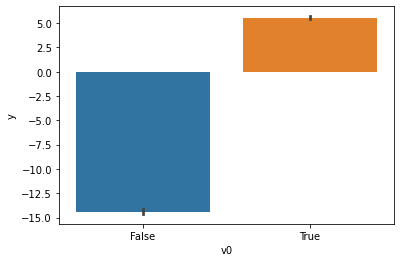

In [12]:
sns.barplot(data=df, x='v0', y='y')

In [23]:
target = 'y'
to_not_include=[
    target, 'v0', 'Z0','Z1'
]
endog=df[target]
exog = sm.add_constant(
        df[[var for var in df.columns if var not in to_not_include]]
).assign(v0=df.v0.apply(lambda x:1 if x == True else 0))
exog.head()

,const,W0,W1,W2,W3,W4,W5,W6,v0
0,1.0,-0.331412,0.296560,0.855238,0.756480,-0.837070,-0.449463,1.195239,1
1,1.0,-0.294763,0.340324,0.784374,-0.291779,-0.812933,-1.076755,0.180778,1
2,1.0,0.118993,0.742025,-0.492677,-0.207602,1.035187,0.405371,-0.743959,1
3,1.0,-1.807608,0.485005,-0.938792,-0.264134,0.412060,-0.682817,-0.634280,1
4,1.0,-0.477996,-1.653827,0.980117,-1.316316,-0.159967,-0.204385,-0.209200,0


In [24]:
# Fit and summarize OLS model
mod = sm.OLS(endog, exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.119e+30
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        03:01:26   Log-Likelihood:             2.7501e+05
No. Observations:               10000   AIC:                        -5.500e+05
Df Residuals:                    9991   BIC:                        -5.499e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.77e-13   8.26e-15     33.538      0.0

In [1]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"], #common_causes=data["common_causes_names"], -- both works the same, but the first is based on a previous graph
        instruments=data["instrument_names"],
        logging_level = logging.INFO # not 100% of its funcionality, but I suppose it serves to gain efficiency
        )

NameError: name 'CausalModel' is not defined

In [ ]:
# dict mapping new column names